<a href="https://colab.research.google.com/github/ykato27/Segmentation/blob/main/3_8_U_Net%E3%81%AB%E3%82%88%E3%82%8B%E3%82%BB%E3%82%B0%E3%83%A1%E3%83%B3%E3%83%86%E3%83%BC%E3%82%B7%E3%83%A7%E3%83%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#U-Netを利用したセマンティック・セグメンテーション

Semantic Segmentation Using U-Net

## 使用するデータセット

これから使用するデータセットは，心臓MRI画像（短軸像）と，それに対し専門家が作成した左心室の部分をマスクした画像です．元のデータは "Sunnybrook Cardiac MR Database" で公開されているものですが，png 画像に直したものが
https://github.com/mitmul/chainer-handson/releases/ 
で公開されています．

The dataset we are going to use is a cardiac MRI image (short axis image) and a masked image of the left ventricle created by experts. The original data is available at "Sunnybrook Cardiac MR Database", while images coverted to the png format are distributed from the above github page.

In [1]:
!if [ ! -d train ]; then curl -L -O https://github.com/mitmul/chainer-handson/releases/download/SegmentationDataset/train.zip && unzip train.zip && rm -rf train.zip; fi
!if [ ! -d val ]; then curl -L -O https://github.com/mitmul/chainer-handson/releases/download/SegmentationDataset/val.zip && unzip val.zip && rm -rf val.zip; fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   615  100   615    0     0   4019      0 --:--:-- --:--:-- --:--:--  4019
100 7533k  100 7533k    0     0  16.6M      0 --:--:-- --:--:-- --:--:-- 30.3M
Archive:  train.zip
   creating: train/
   creating: train/image/
  inflating: train/image/000.png     
  inflating: train/image/001.png     
  inflating: train/image/002.png     
  inflating: train/image/003.png     
  inflating: train/image/004.png     
  inflating: train/image/005.png     
  inflating: train/image/006.png     
  inflating: train/image/007.png     
  inflating: train/image/008.png     
  inflating: train/image/009.png     
  inflating: train/image/010.png     
  inflating: train/image/011.png     
  inflating: train/image/012.png     
  inflating: train/image/013.png     
  inflating: train/image/014.png     
  inflating: train/image/015.png     
  inflatin

このデータセットから抜き出した画像ペアの例を示します．

Here is an example of an image pair extracted from this dataset.

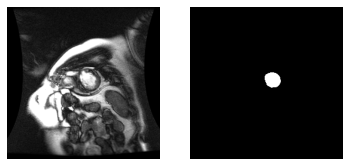

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

# PILライブラリで画像を読み込む
img = np.asarray(Image.open('train/image/000.png'))
label = np.asarray(Image.open('train/label/000.png'))

# matplotlibライブラリを使って2つの画像を並べて表示
fig, axes = plt.subplots(1, 2)
axes[0].set_axis_off()
axes[0].imshow(img, cmap='gray')
axes[1].set_axis_off()
axes[1].imshow(label, cmap='gray')
plt.show()

左が心臓のMRI画像，右がその中で左心室をマスクしたものです．

The left is an MRI image of the heart, and the right is a masked image of the left ventricle in it.

In [3]:
img.shape

(256, 256)

NumPy配列に変換する

Converting to NumPy arrays

In [4]:
import numpy as np
import glob
import cv2
import os
import sys

def get_image_array(directory):
  image_list =[]
  #画像が保存してあるディレクトリからすべてのファイル名を取得
  files = glob.glob(directory+'/*')
  #すべての画像ファイルについて以下を実行
  for imgfile in files:
    img = cv2.imread(imgfile,0) #cv2でグレースケールで読み込み
    image_list.append(img.reshape(256,256,1))
  images = np.array(image_list) 
  return images
 
image_train = get_image_array('/content/train/image')/255.0 #値を[0,1]に正規化
label_train = get_image_array('/content/train/label')       #labelは始めから正規化されている
image_val = get_image_array('/content/val/image')/255.0
label_val = get_image_array('/content/val/label')

U-netの定義

Definition of U-net

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Conv2DTranspose, Cropping2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Activation, Dropout

def UNet(input_channel_count=1, output_channel_count=1, first_layer_filter_count=64):
    
  INPUT_IMAGE_SIZE = 256
  CONV_FILTER_SIZE = 4
  CONV_STRIDE = 2
  DECONV_FILTER_SIZE = 2
  DECONV_STRIDE = 2

  # (256 x 256 x input_channel_count)
  inputs = Input((INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE, input_channel_count))

  # エンコーダーの作成
  # (128 x 128 x N)
  enc1 = Conv2D(first_layer_filter_count, CONV_FILTER_SIZE, strides=CONV_STRIDE, padding='same')(inputs)

  # (64 x 64 x 2N)
  filter_count = first_layer_filter_count*2
  enc2 = _add_encoding_layer(filter_count, enc1)

  # (32 x 32 x 4N)
  filter_count = first_layer_filter_count*4
  enc3 = _add_encoding_layer(filter_count, enc2)

  # (16 x 16 x 8N)
  filter_count = first_layer_filter_count*8
  enc4 = _add_encoding_layer(filter_count, enc3)

  # (8 x 8 x 8N)
  enc5 = _add_encoding_layer(filter_count, enc4)

  # (4 x 4 x 8N)
  enc6 = _add_encoding_layer(filter_count, enc5)

  # (2 x 2 x 8N)
  enc7 = _add_encoding_layer(filter_count, enc6)

  # (1 x 1 x 8N)
  enc8 = _add_encoding_layer(filter_count, enc7)

  # デコーダーの作成
  # (2 x 2 x 8N)
  dec1 = _add_decoding_layer(filter_count, True, enc8)
  dec1 = Concatenate()([dec1, enc7])

  # (4 x 4 x 8N)
  dec2 = _add_decoding_layer(filter_count, True, dec1)
  dec2 = Concatenate()([dec2, enc6])

  # (8 x 8 x 8N)
  dec3 = _add_decoding_layer(filter_count, True, dec2)
  dec3 = Concatenate()([dec3, enc5])

  # (16 x 16 x 8N)
  dec4 = _add_decoding_layer(filter_count, False, dec3)
  dec4 = Concatenate()([dec4, enc4])

  # (32 x 32 x 4N)
  filter_count = first_layer_filter_count*4
  dec5 = _add_decoding_layer(filter_count, False, dec4)
  dec5 = Concatenate()([dec5, enc3])

  # (64 x 64 x 2N)
  filter_count = first_layer_filter_count*2
  dec6 = _add_decoding_layer(filter_count, False, dec5)
  dec6 = Concatenate()([dec6, enc2])

  # (128 x 128 x N)
  filter_count = first_layer_filter_count
  dec7 = _add_decoding_layer(filter_count, False, dec6)
  dec7 = Concatenate()([dec7, enc1])

  # (256 x 256 x output_channel_count)
  dec8 = Activation(activation='relu')(dec7)
  dec8 = Dropout(0.5)(dec8)
  dec8 = Conv2DTranspose(output_channel_count, DECONV_FILTER_SIZE, strides=DECONV_STRIDE)(dec8)
  dec8 = Activation(activation='sigmoid')(dec8)

  return Model(inputs=inputs, outputs=dec8)

def _add_encoding_layer(filter_count, sequence):
    new_sequence = LeakyReLU(0.2)(sequence)
    new_sequence = Conv2D(filter_count, 4, strides=2, padding="same")(new_sequence)
    new_sequence = BatchNormalization()(new_sequence)
    return new_sequence
def _add_decoding_layer(filter_count, add_drop_layer, sequence):
    new_sequence = Activation(activation='relu')(sequence)
    new_sequence = Conv2DTranspose(filter_count, 4, strides=2, padding='same',
                                    kernel_initializer='he_uniform')(new_sequence)
    new_sequence = BatchNormalization()(new_sequence)
    if add_drop_layer:
        new_sequence = Dropout(0.5)(new_sequence)
    return new_sequence

モデルを生成

Creating the model

In [6]:
model = UNet()

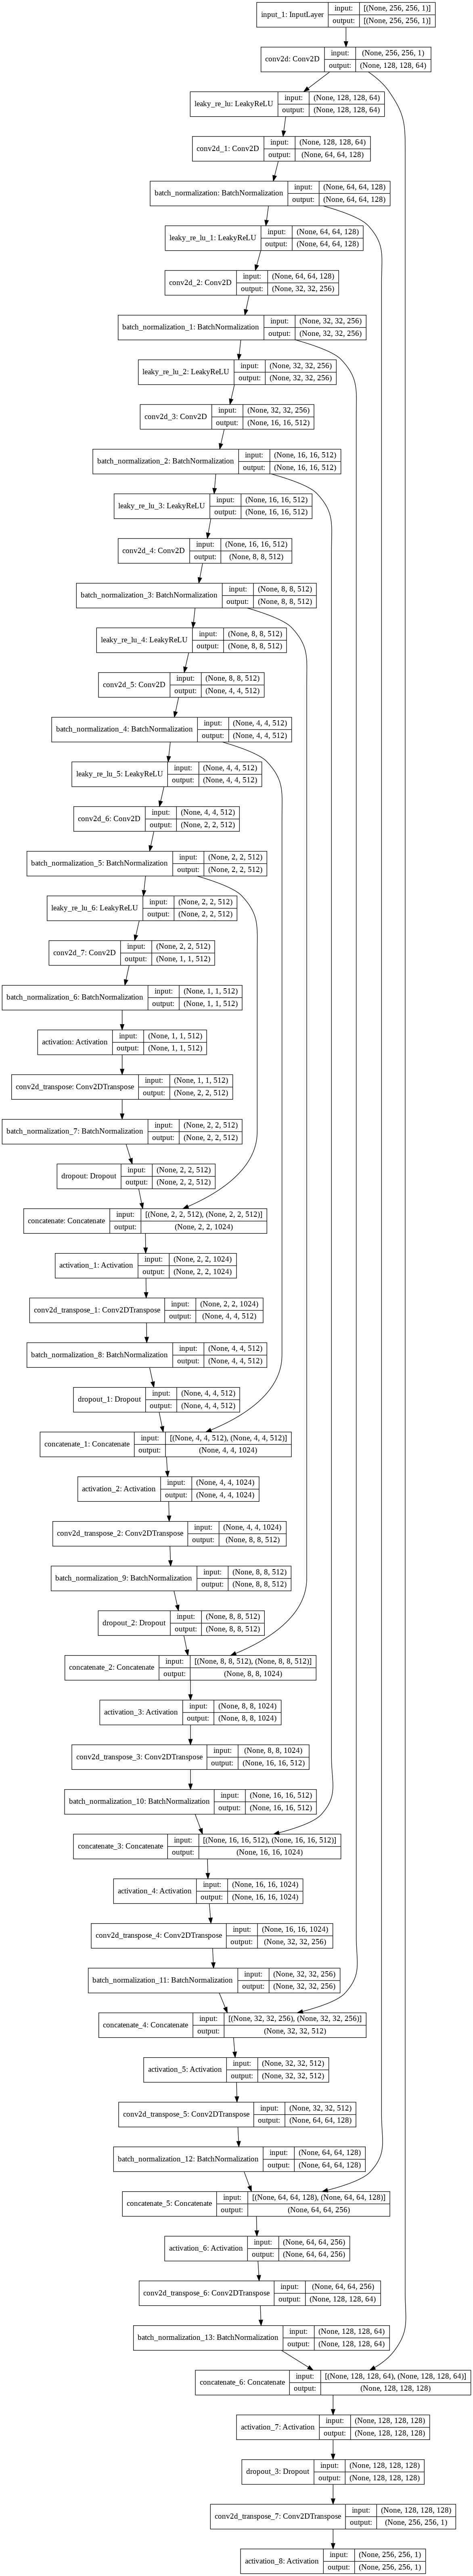

In [7]:
#モデルのグラフを表示
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes = True)

コンパイルと学習（30エポック）

Complie and training (30 epochs)

In [8]:
from tensorflow.keras.optimizers import Adam
model.compile( Adam(lr=1e-3), loss="binary_crossentropy", metrics=["acc"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


メモリーが足りなくて止まってしまう場合は `batch_size` を小さくしてください．

If the program stops due to memory shortage, reduce the `batch_size`.




In [9]:
history = model.fit(image_train, label_train, batch_size=32, epochs = 30, 
                    verbose=1,validation_data=(image_val,label_val))

Epoch 1/30
8/8 [==============================] - 54s 2s/step - loss: 0.6391 - acc: 0.6939 - val_loss: 1.3156 - val_acc: 0.5644
Epoch 2/30
8/8 [==============================] - 9s 1s/step - loss: 0.4959 - acc: 0.9163 - val_loss: 1.1409 - val_acc: 0.6367
Epoch 3/30
8/8 [==============================] - 8s 1s/step - loss: 0.3972 - acc: 0.9712 - val_loss: 0.6119 - val_acc: 0.8036
Epoch 4/30
8/8 [==============================] - 8s 1s/step - loss: 0.3135 - acc: 0.9820 - val_loss: 0.4666 - val_acc: 0.8975
Epoch 5/30
8/8 [==============================] - 8s 1s/step - loss: 0.2427 - acc: 0.9845 - val_loss: 0.8976 - val_acc: 0.8100
Epoch 6/30
8/8 [==============================] - 8s 1s/step - loss: 0.1880 - acc: 0.9853 - val_loss: 0.9929 - val_acc: 0.8230
Epoch 7/30
8/8 [==============================] - 8s 1s/step - loss: 0.1482 - acc: 0.9859 - val_loss: 0.6806 - val_acc: 0.8757
Epoch 8/30
8/8 [==============================] - 8s 1s/step - loss: 0.1191 - acc: 0.9868 - val_loss: 0.5310 -

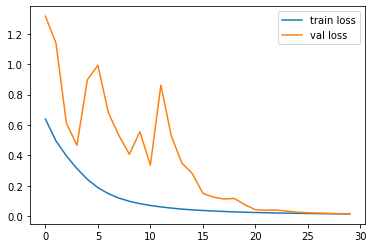

In [10]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
x = np.arange(len(train_loss))
plt.plot(x, train_loss, label = 'train loss')
plt.plot(x, val_loss, label = 'val loss ')
plt.legend() #グラフの線の説明を表示

結果の表示（元の画像，正解画像，予測画像の順）


すべての評価データに対して実行

Display the results (original image, correct image, predicted image, from left)


Performed on all evaluation data

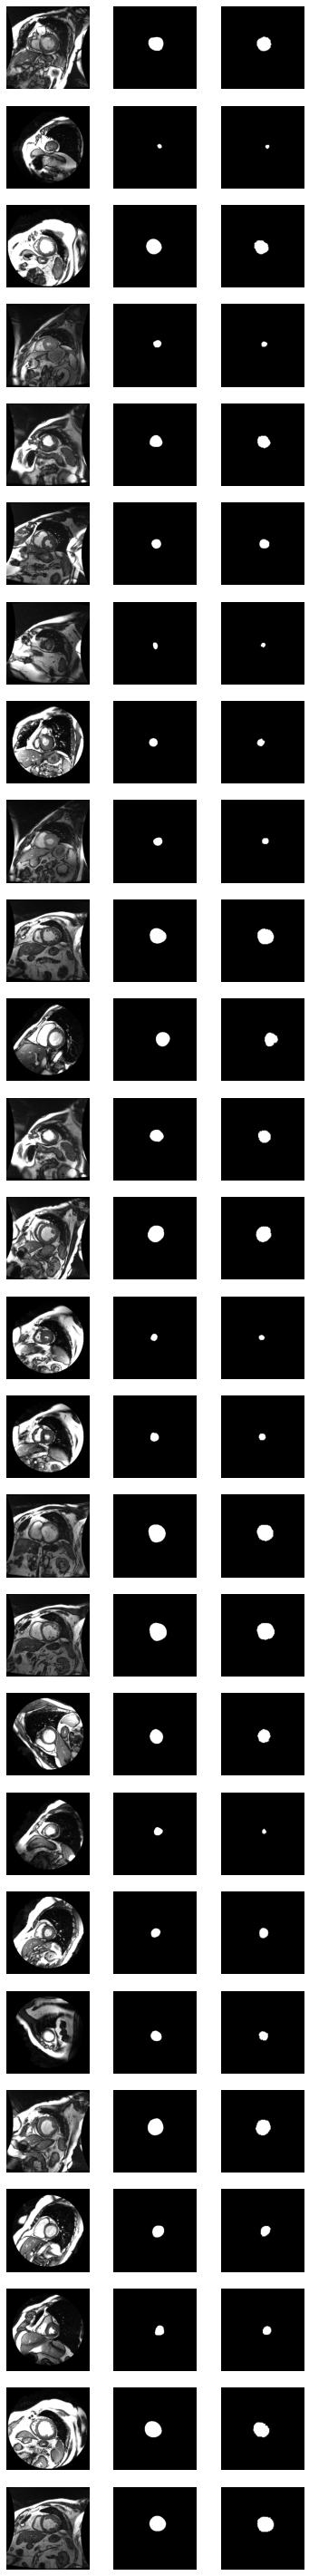

In [11]:
predict = model.predict(image_val)

num = len(image_val)
fig, axes = plt.subplots(num, 3, figsize=(6, 2*num))
for i in range(num):
  img = image_val[i].reshape(256,256)
  label = label_val[i].reshape(256,256)
  gen_img = predict[i].reshape(256,256)
  gen_img_two = np.zeros_like(gen_img)
  gen_img_two = (gen_img > 0.5) *1.0

  # matplotlibライブラリを使って2つの画像を並べて表示  
  axes[i,0].set_axis_off()
  axes[i,0].imshow(img, cmap='gray')
  axes[i,1].set_axis_off()
  axes[i,1].imshow(label, cmap='gray')
  axes[i,2].set_axis_off()
  axes[i,2].imshow(gen_img_two, cmap='gray')


##U-netの改良 Improvement of U-net


上のモデルでも十分良いのですが，改良を試みます．

よくあるU-Netは
```
          分岐 -  Activation - Conv - BatchNorm - 合流
```
の順ですが， ResNet と同様に 
```
          分岐 - BatchNorm - Activation - Conv - 合流
```
とした方が性能が上がります．

同じ条件（バッチサイズ32）で15エポック学習したときの精度を比較すると 
```
   U-Net         : val_loss: 0.0479
   U-Net_refined : val_loss: 0.0350
```
という程度です．（loss は全ピクセル・全データに関する平均（2値）交差エントロピー）

The above model is good enough, but we try to improve it.

While a common U-Net is as
```
          Branching - Activation - Conv - BatchNorm - Confluence
BatchNorm - Merge
```
the perforamance is improved it it is changed to as
```
          Branching - BatchNorm - Activation - Conv - Confluence
branch - BatchNorm - Activation - Conv - merge
```

Comparing the accuracy of 15 epochs of training under the same conditions (batch size 32) . The validation losses become like
```.
   U-Net : val_loss: 0.0479
   U-Net_refined : val_loss: 0.0350
``` 
 (Loss is the average (binary) cross-entropy for all pixels and all data.)

In [12]:
import tensorflow.keras.backend as K
K.clear_session()

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Conv2DTranspose, Cropping2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Activation, Dropout

def UNet_refined(input_channel_count=1, output_channel_count=1, first_layer_filter_count=64):
    
  INPUT_IMAGE_SIZE = 256
  CONV_FILTER_SIZE = 4
  CONV_STRIDE = 2
  DECONV_FILTER_SIZE = 2
  DECONV_STRIDE = 2

  # (256 x 256 x input_channel_count)
  inputs = Input((INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE, input_channel_count))

  # エンコーダーの作成
  # (128 x 128 x N)
  enc1 = Conv2D(first_layer_filter_count, CONV_FILTER_SIZE, strides=CONV_STRIDE, padding='same')(inputs)

  # (64 x 64 x 2N)
  filter_count = first_layer_filter_count*2
  enc2 = _add_encoding_layer(filter_count, enc1)

  # (32 x 32 x 4N)
  filter_count = first_layer_filter_count*4
  enc3 = _add_encoding_layer(filter_count, enc2)

  # (16 x 16 x 8N)
  filter_count = first_layer_filter_count*8
  enc4 = _add_encoding_layer(filter_count, enc3)

  # (8 x 8 x 8N)
  enc5 = _add_encoding_layer(filter_count, enc4)

  # (4 x 4 x 8N)
  enc6 = _add_encoding_layer(filter_count, enc5)

  # (2 x 2 x 8N)
  enc7 = _add_encoding_layer(filter_count, enc6)

  # (1 x 1 x 8N)
  enc8 = _add_encoding_layer(filter_count, enc7)

  # デコーダーの作成
  # (2 x 2 x 8N)
  dec1 = _add_decoding_layer(filter_count, True, enc8)
  dec1 = Concatenate()([dec1, enc7])

  # (4 x 4 x 8N)
  dec2 = _add_decoding_layer(filter_count, True, dec1)
  dec2 = Concatenate()([dec2, enc6])

  # (8 x 8 x 8N)
  dec3 = _add_decoding_layer(filter_count, True, dec2)
  dec3 = Concatenate()([dec3, enc5])

  # (16 x 16 x 8N)
  dec4 = _add_decoding_layer(filter_count, False, dec3)
  dec4 = Concatenate()([dec4, enc4])

  # (32 x 32 x 4N)
  filter_count = first_layer_filter_count*4
  dec5 = _add_decoding_layer(filter_count, False, dec4)
  dec5 = Concatenate()([dec5, enc3])

  # (64 x 64 x 2N)
  filter_count = first_layer_filter_count*2
  dec6 = _add_decoding_layer(filter_count, False, dec5)
  dec6 = Concatenate()([dec6, enc2])

  # (128 x 128 x N)
  filter_count = first_layer_filter_count
  dec7 = _add_decoding_layer(filter_count, False, dec6)
  dec7 = Concatenate()([dec7, enc1])

  # (256 x 256 x output_channel_count)
  dec8 = BatchNormalization()(dec7)
  dec8 = Activation(activation='relu')(dec8)
  dec8 = Dropout(0.5)(dec8)
  dec8 = Conv2DTranspose(output_channel_count, DECONV_FILTER_SIZE, strides=DECONV_STRIDE)(dec8)
  dec8 = Activation(activation='sigmoid')(dec8)

  return Model(inputs=inputs, outputs=dec8)

def _add_encoding_layer(filter_count, sequence):
    new_sequence = BatchNormalization()(sequence)
    new_sequence = LeakyReLU(0.2)(new_sequence)
    new_sequence = Conv2D(filter_count, 4, strides=2, padding="same")(new_sequence)    
    return new_sequence
def _add_decoding_layer(filter_count, add_drop_layer, sequence):
    new_sequence = BatchNormalization()(sequence)
    new_sequence = Activation(activation='relu')(new_sequence)
    if add_drop_layer:
        new_sequence = Dropout(0.5)(new_sequence)
    new_sequence = Conv2DTranspose(filter_count, 4, strides=2, padding='same', 
                                    kernel_initializer='he_uniform')(new_sequence)
    return new_sequence

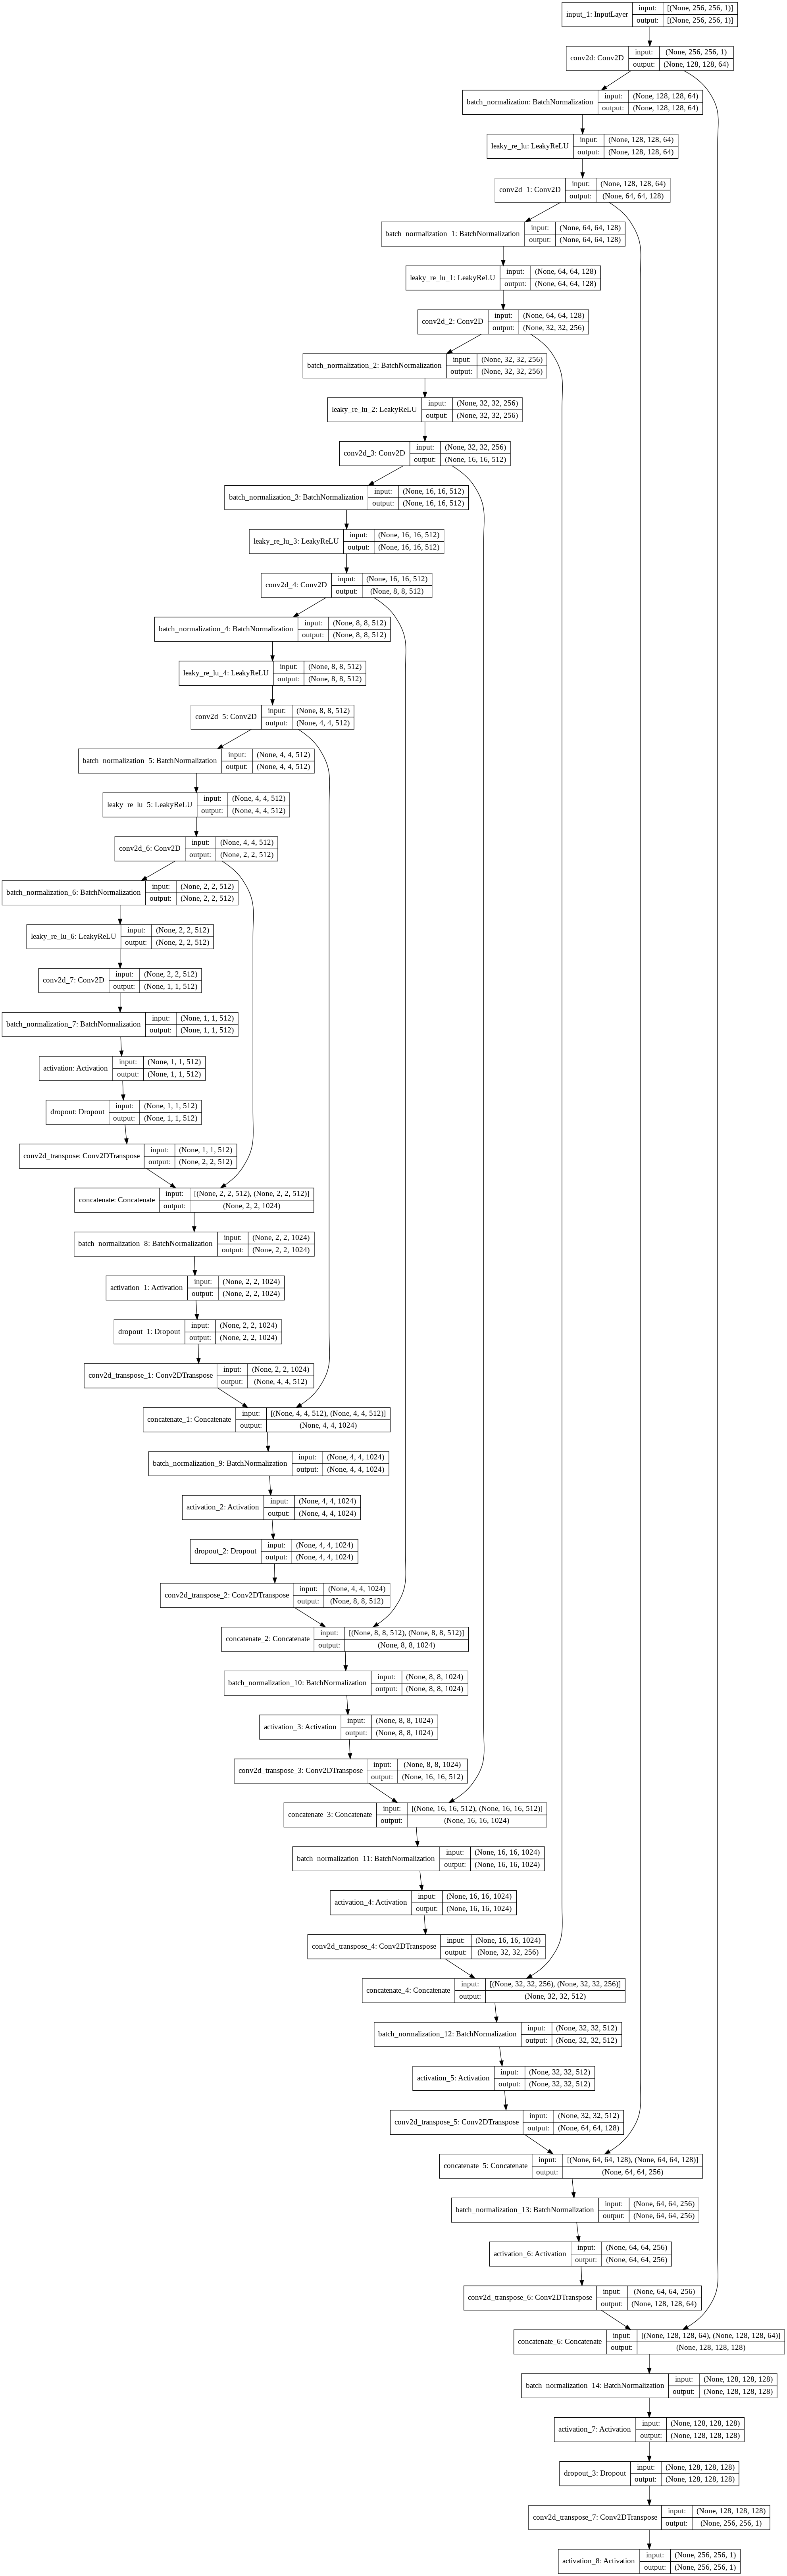

In [13]:
model = UNet_refined()

#モデルのグラフを表示
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes = True)

In [14]:
from tensorflow.keras.optimizers import Adam
model.compile( Adam(lr=1e-3), loss="binary_crossentropy", metrics=["acc"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


学習係数を途中で小さくしながら50エポック学習

50 epoch learning with decreasing learning coefficients along the way

In [15]:
from tensorflow.keras.callbacks import LearningRateScheduler

#schedulerの設定
def step_decay(epoch):
    x = 0.001
    if epoch >= 30: x = 0.0003
    if epoch >= 40: x = 0.0001
    return x
decay = LearningRateScheduler(step_decay, verbose=0)

history = model.fit(image_train, label_train, batch_size=32, epochs = 50,
                    verbose=2, validation_data=(image_val,label_val), callbacks=[decay])


Epoch 1/50
8/8 - 11s - loss: 0.6019 - acc: 0.7252 - val_loss: 1.8415 - val_acc: 0.4385
Epoch 2/50
8/8 - 9s - loss: 0.4046 - acc: 0.9404 - val_loss: 1.2625 - val_acc: 0.6205
Epoch 3/50
8/8 - 9s - loss: 0.3095 - acc: 0.9737 - val_loss: 0.5116 - val_acc: 0.8824
Epoch 4/50
8/8 - 9s - loss: 0.2434 - acc: 0.9810 - val_loss: 0.4369 - val_acc: 0.9436
Epoch 5/50
8/8 - 9s - loss: 0.1961 - acc: 0.9829 - val_loss: 0.4512 - val_acc: 0.9776
Epoch 6/50
8/8 - 9s - loss: 0.1583 - acc: 0.9838 - val_loss: 0.5265 - val_acc: 0.8975
Epoch 7/50
8/8 - 9s - loss: 0.1310 - acc: 0.9849 - val_loss: 0.5179 - val_acc: 0.9121
Epoch 8/50
8/8 - 8s - loss: 0.1097 - acc: 0.9860 - val_loss: 0.7073 - val_acc: 0.8733
Epoch 9/50
8/8 - 8s - loss: 0.0926 - acc: 0.9875 - val_loss: 0.4426 - val_acc: 0.9346
Epoch 10/50
8/8 - 8s - loss: 0.0787 - acc: 0.9889 - val_loss: 0.7013 - val_acc: 0.9196
Epoch 11/50
8/8 - 8s - loss: 0.0675 - acc: 0.9903 - val_loss: 0.5482 - val_acc: 0.9380
Epoch 12/50
8/8 - 8s - loss: 0.0585 - acc: 0.9915 -

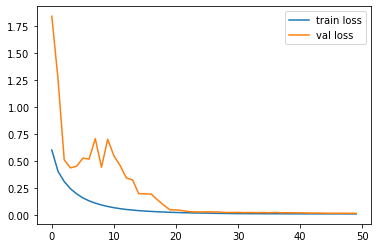

In [16]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
x = np.arange(len(train_loss))
plt.plot(x, train_loss, label = 'train loss')
plt.plot(x, val_loss, label = 'val loss ')
plt.legend() #グラフの線の説明を表示

結果の表示（元の画像，正解画像，予測画像の順）


すべての評価データに対して実行

Display the results (original image, correct image, predicted image, from left)


Performed on all evaluation data

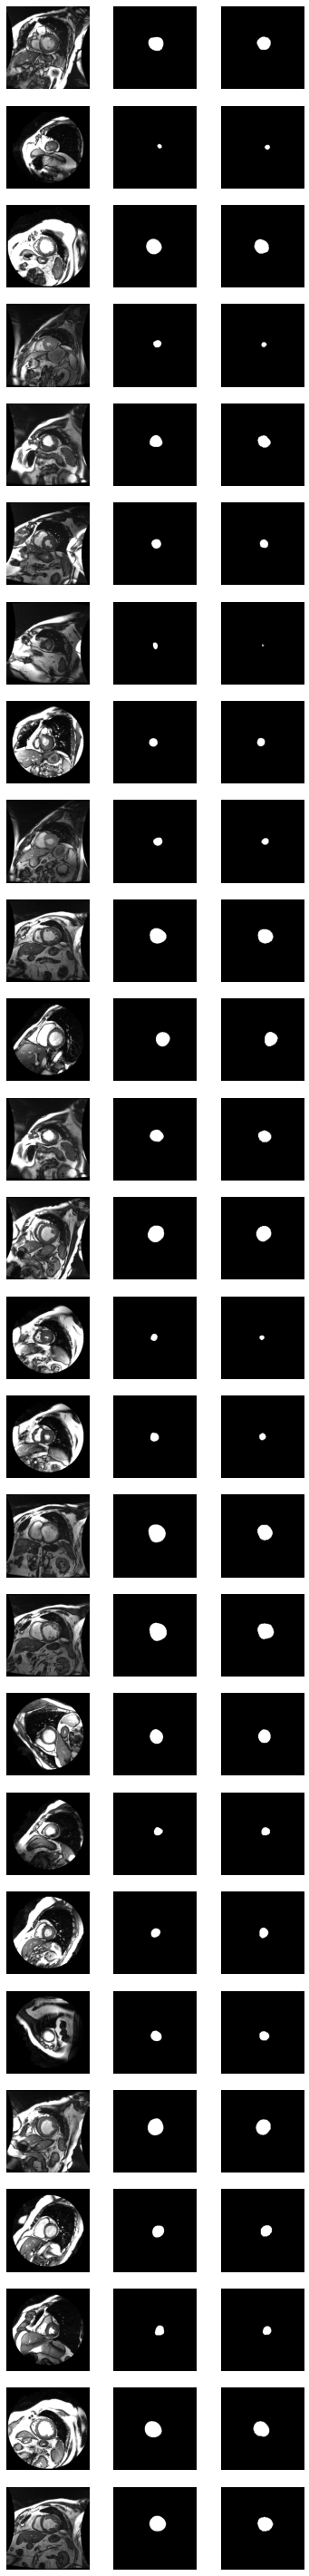

In [17]:
# PILライブラリで画像を読み込む
predict = model.predict(image_val)

num = len(image_val)
fig, axes = plt.subplots(num, 3, figsize=(6, 2*num))
for i in range(num):
  img = image_val[i].reshape(256,256)
  label = label_val[i].reshape(256,256)
  gen_img = predict[i].reshape(256,256)
  gen_img_two = np.zeros_like(gen_img)
  gen_img_two = (gen_img > 0.5) *1.0

  # matplotlibライブラリを使って2つの画像を並べて表示  
  axes[i,0].set_axis_off()
  axes[i,0].imshow(img, cmap='gray')
  axes[i,1].set_axis_off()
  axes[i,1].imshow(label, cmap='gray')
  axes[i,2].set_axis_off()
  axes[i,2].imshow(gen_img_two, cmap='gray')
